# AWS DC Summit 2023 | Machine Learning Builders' Session

### AIM204: Unleash the power of automation to revolutionize document processing

### Lab 1

---

## Introduction
Amazon Textract is a machine learning (ML) service that automatically extracts text, handwriting, and data from scanned documents. It goes beyond simple optical character recognition (OCR) to identify, understand, and extract data from forms and tables. In this session we will demonstrate how to programatically use Amazon Textract to solve common intelligent document processing challenges such as: detecting text within a document, analyzing a document for relationships between detected items, using asynchronous operations for batch processing, analyzing a document for financially-related relationships between text, and more. 

</p>

- 1. [Prerequisites](#section_1_0)
    - 1.1 [Install packages](#section_1_1)
    - 1.2 [Import packages and modules](#section_1_2)
    - 1.3 [Setup the notebook role and session](#section_1_3)
    - 1.4 [Setup the AWS service clients](#section_1_4)
- 2. [An Introduction to Document Processing with Amazon Textract](#section_2_0)
    - 2.1 [Sample document for text detection](#section_2_1)
    - 2.2 [Detecting document text](#section_2_2)
    - 2.3 [Amazon Textract Response Objects](#section_2_3)
    - 2.4 [Visualizing the Response Objects Hierarchy](#section_2_4)
- 3. [Asynchronous processing](#section_3_0)
    - 3.1 [Sample document for asynchronous processing](#section_3_1)
    - 3.2 [Asynchronous Document Analysis](#section_3_2)
    - 3.3 [Asynchronous process workflow](#section_3_3)
- 4. [Expense Document Analysis](#section_4_0)
    - 4.1 [Sample document for expense document analysis processing](#section_4_1)
    - 4.2 [Execute a synchronous analyze expense job](#section_4_2)
    - 4.3 [Asynchronous process workflow](#section_4_3)
- 5. [Processing Identity Documents](#section_5_0)
    - 5.1 [Sample document for identity document analysis processing](#section_5_1)
    - 5.2 [Execute a synchronous analyze identity process](#section_5_2)
    - 5.3 [Sample identity document for document analysis queries](#section_5_3)
    - 5.3 [Processing a U.S. Social Security Card with Queries](#section_5_4)    
- 6. [Document Enrichment using Redaction (Optional)](#section_6_0)
- 7. [Conclusion](#section_7_0)
- 8. [Additional Resources](#section_8_0)

##### **Let's get started!**

---

## 1. Prerequisites
<a id=section_1_0></a>

In this section, we'll install and import packages, establish the notebook execution role and session, and setup the AWS service clients.

### 1.1 Install packages
<a id=section_1_1></a>

We use *pip* to install packages from the Python Package Index and other indexes. A package contains all the files you need for a module.
Modules are Python code libraries you can include in your project. You can think of Python packages as the directories on a file system and modules as files within directories. 

**Note:** after executing code in this cell there will be lots of debug output, this is normal, and expected.

In [2]:
!pip install amazon-textract-caller
!pip install amazon-textract-prettyprinter
!pip install amazon-textract-response-parser 
!pip install boto3 
!pip install botocore 
!pip install s3fs
!pip install textract-trp 


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


### 1.2 Import packages and modules
<a id=section_1_2></a>

Python code in one module gains access to the code in another module by the process of importing it. In this section, we import packages and modules needed to execute code cells in this notebook.

In [3]:
import sagemaker
import boto3
import s3fs
import time
import json
import io
from io import BytesIO

from PIL import Image, ImageDraw, ImageOps

from trp import Document
import urllib.request

from textractcaller import call_textract_analyzeid
import trp.trp2_analyzeid as t2id

from tabulate import tabulate
import trp.trp2 as t2

### 1.3 Setup the notebook role and session
<a id=section_1_3></a>

As a managed service, Amazon SageMaker performs operations on your behalf on the AWS hardware that is managed by SageMaker. SageMaker can perform only operations that the user permits. A SageMaker user can grant these permissions with an IAM role (referred to as an execution role).

To create and use a locally available execution role, execute the code in the following cell

In [4]:
# Get the IAM role and Sagemaker session
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

# Get the SakeMaker session
session = sagemaker.Session()

# Get the region name
region = session.boto_region_name

print('Using IAM role arn: {}'.format(role))
print('Using region: {}'.format(region))

Using IAM role arn: arn:aws:iam::354457949231:role/service-role/AmazonSageMaker-ExecutionRole-20200403T155034
Using region: us-east-1


### 1.4 Setup the AWS service clients
<a id=section_1_4></a>

AWS' Boto3 library is used commonly to integrate Python applications with various AWS services. Clients provide a low-level interface to the AWS service. In this section, we will create two Boto3 clients: s3 and textract, to help execute code cells in this notebook.

In [5]:
# Setup the S3 client
s3_client = boto3.client('s3')

# Setup the Textract client
textract_client = boto3.client('textract', region_name=region)

# Get bucket settings
s3_bucket = session.default_bucket()
s3_bucket_prefix = 'aim204/sample-files'

# The path to our files in the S3 bucket
print('Using S3 path: {}/{}'.format(s3_bucket, s3_bucket_prefix))

Using S3 path: sagemaker-us-east-1-354457949231/aim204/sample-files


## 2. An Introduction to Document Processing with Amazon Textract
<a id=section_2_0></a>

In this section, we'll demonstrate how to programatically use the Amazon Textract SDK to handle processing common document types.

### 2.1 Sample document for text detection
<a id=section_2_1></a>

Let's have a look at the sample input document we'll use as input for Amazon Textract to detect the document's text

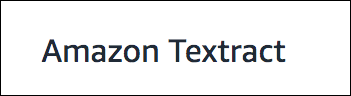

In [6]:
# A sample PNG image file that contains a single line of text
file_name = "OneLine.png"

# The location of the sample PNG image file in your Amazon S3 bucket.
object_key = '{}/{}'.format(s3_bucket_prefix, file_name)

# Display the PNG image 
fs = s3fs.S3FileSystem()
with fs.open('{}/{}'.format(s3_bucket, object_key)) as f:
    display(ImageOps.expand(Image.open(f),border=1,fill='black'))

### 2.2 Detecting document text
<a id=section_2_2></a>

In this code cell, we'll be calling Textract to synchronously process a PNG image document containing a single line of text. This is a simple example to help us become familiar with the Amazon Textract request and response syntax. You can consider this example the 'Hello World' of progamatically leveraging Amazon Textract.

In [7]:
# Call Amazon Textract
detect_text_response = textract_client.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3_bucket,
            'Name': object_key
        }
    }
)

# Display the single line of text in the PNG file detected by Textract
for item in detect_text_response["Blocks"]:
    if item["BlockType"] == "LINE":
        print('The line of text detected by Amazon Textract from our sample PNG image file is, you guessed it: {}\n'.format(item["Text"]))

The line of text detected by Amazon Textract from our sample PNG image file is, you guessed it: Amazon Textract



### 2.3 Amazon Textract Response Objects
<a id=section_2_3></a>

Before we dive deeper into the lab, let's take a minute or two to better understand Amazon Textract Response Objects.

Amazon Textract **operations return different types of objects depending on the operations run**. 

- For **detecting text and analyzing a generic document**, the operation **returns a Block object**. 
- For **analyzing an invoice or receipt**, the operation **returns an ExpenseDocuments object**. 
- For **analyzing identity documentation**, the operation **returns an IdentityDocumentFields object**.

In [8]:
# Let's inspect the Amazon Textract Response Objects for detecting text (returned from the previous cell)

print('The Amazon Textract Response Objects for invoking detect_document_text:\n')
print(json.dumps(detect_text_response, indent=4))

The Amazon Textract Response Objects for invoking detect_document_text:

{
    "DocumentMetadata": {
        "Pages": 1
    },
    "Blocks": [
        {
            "BlockType": "PAGE",
            "Geometry": {
                "BoundingBox": {
                    "Width": 1.0,
                    "Height": 1.0,
                    "Left": 0.0,
                    "Top": 0.0
                },
                "Polygon": [
                    {
                        "X": 0.00013841662439517677,
                        "Y": 0.0
                    },
                    {
                        "X": 1.0,
                        "Y": 1.1879767953359988e-05
                    },
                    {
                        "X": 1.0,
                        "Y": 1.0
                    },
                    {
                        "X": 0.0,
                        "Y": 1.0
                    }
                ]
            },
            "Id": "3d484e1e-6422-4964-8f45-eeec9c24de94"

### 2.4 Visualizing the Response Objects Hierarchy
<a id=section_2_4></a>

To help us visualize the hierachy of the Amazon Textract response objects for detecting text, here's an illustration of a portion of the JSON response object hierarchy

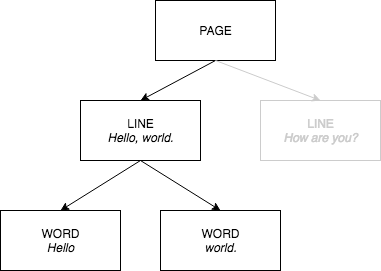

In [9]:
urllib.request.urlretrieve(
  'https://docs.aws.amazon.com/images/textract/latest/dg/images/hieroglyph-text-detection.png', 'textract-pages-lines-words.png')
img = Image.open("textract-pages-lines-words.png")
display(img)

In our example, the Amazon Textract Response contains one **PAGE** BlockType, which contains one child **LINE** BlockType, which contains two children **WORD** BlockTypes.

Additionally, the **LINE** BlockType contains the value **'Amazon Textract'** and also has two child **WORD** BlockTypes which are: **Amazon** and **Textract**

Referencing the **Ids** list object within the **Relationships** list object is helpful for understanding the hierarchical relationships between Amazon Textract Response objects. We've included some additional resources at the end of this notebook for further reading on this topic.

Lastly, **Confidence** scores are numeric values ranging between 0 and 100 that indicate the probability that a given prediction is correct, where highly confident scores will be closer to 100.

## 3. Asynchronous processing
<a id=section_3_0></a>

In this section, we'll introduce the concept of Textract Asynchronous Operations, which queue incoming requests and processes them asynchronously. By using asynchronous jobs, documents can be processed without blocking computing resources. 

Amazon Textract provides an asynchronous API that you can use to process **multipage** documents in **PDF or TIFF** format. You can also use asynchronous operations to process **single-page** documents that are in **JPEG, PNG, TIFF, or PDF** format.

### 3.1 Sample document for asynchronous processing
<a id=section_3_1></a>

Let's have a look at the sample input document we'll use as input for Amazon Textract to detect document's text

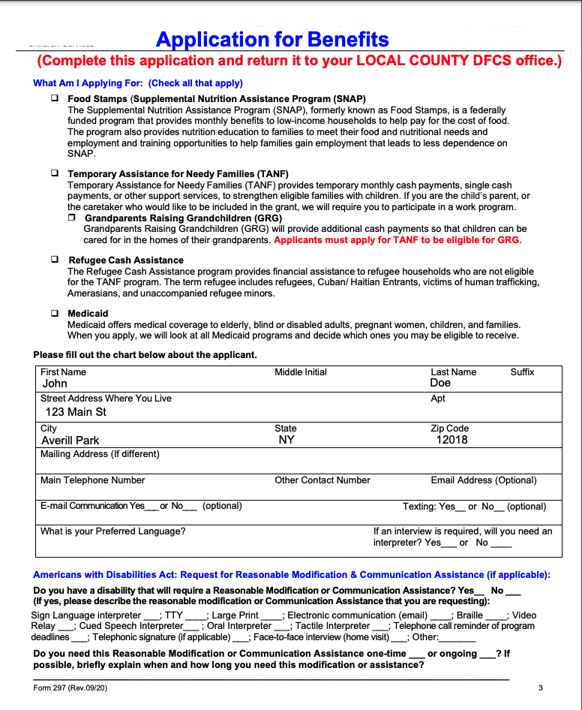

In [10]:
# Sample document
file_name = "Benefit_Application_Form_John_Doe.png"

# The location of the sample PNG image file in your Amazon S3 bucket.
object_key = '{}/{}'.format(s3_bucket_prefix, file_name)

# Display the PNG image 
fs = s3fs.S3FileSystem()
with fs.open('{}/{}'.format(s3_bucket, object_key)) as f:
    display(ImageOps.scale(Image.open(f),0.75))

### 3.2 Asynchronous Document Analysis
<a id=section_3_2></a>

In this section we'll start a document analysis job that will analyze a sample benefits application form to find relationships between detected items. The document analysis job will return a job identifier (JobId) as a reference to the job.

We'll also create three helper functions for asynchronously processing a Textract Document Analysis Job.

1. **start_analyze_job**: responsible for initiating the asynchronous document analysis job of a benefit application form document
2. **is_job_complete**: periodically checks for job status completion (i.e. no longer IN_PROGRESS)
3. **get_job_results**: gets the results from the Amazon Textract asynchronous job we executed


In [11]:
def start_analyze_job(s3_bucket, key_name):
    response = None
    response = textract_client.start_document_analysis(
        DocumentLocation={
            'S3Object': {
                'Bucket': s3_bucket,
                'Name': key_name
            }
        },
        FeatureTypes=['FORMS'],
        OutputConfig={
            'S3Bucket': s3_bucket,
            'S3Prefix': 'textract-output/benefit-app'
        }
    )
    
    return response["JobId"]

def is_job_complete(jobId):
    response = textract_client.get_document_analysis(JobId=jobId)
    status = response["JobStatus"]
    print("Job status: {}".format(status))

    while(status == "IN_PROGRESS"):
        time.sleep(5)
        response = textract_client.get_document_analysis(JobId=jobId)
        status = response["JobStatus"]
        print("Job status: {}".format(status))

    return status

def get_job_results(jobId):
    pages = []
    response = textract_client.get_document_analysis(JobId=jobId)
    pages.append(response)
    print("Result page recieved: {}".format(len(pages)))
    nextToken = None
    if('NextToken' in response):
        nextToken = response['NextToken']

    while(nextToken):
        response = textract_client.get_document_analysis(JobId=jobId, NextToken=nextToken)

        pages.append(response)
        print("Result page recieved: {}".format(len(pages)))
        nextToken = None
        if('NextToken' in response):
            nextToken = response['NextToken']
    
    return pages

In [12]:
# Start the asynchronous processing job
job_id = start_analyze_job(s3_bucket, object_key)

# Print the JobId and the input document location
print("Started an asynchronous Analyze Document Job with job_id: {}".format(job_id))
print("Input document URI: {}\n".format(object_key))

# Invoke our helper functions to check the job status and get the results
if(is_job_complete(job_id)):
    benefit_application_response = get_job_results(job_id)

# Use the Textract Response Parser library to easily parser JSON returned by Amazon Textract
doc = Document(benefit_application_response)

# Display the key/value pairs detected by the Analyze Document Job
print("Result Fields:")

for field in doc.pages[0].form.fields:
    print("Key: {}, Value: {}".format(field.key, field.value))

Started an asynchronous Analyze Document Job with job_id: 2d3ef282f8cb991e48ee8bd0d71717d19d675f4d766f550711a01590811cabec
Input document URI: aim204/sample-files/Benefit_Application_Form_John_Doe.png

Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: SUCCEEDED
Result page recieved: 1
Result Fields:
Key: Street Address Where You Live, Value: 123 Main St
Key: No, Value: None
Key: Middle Initial, Value: None
Key: First Name, Value: John
Key: City, Value: Averill Park
Key: Last Name, Value: Doe
Key: Zip Code, Value: 12018
Key: State, Value: NY
Key: Email Address (Optional), Value: None
Key: No, Value: None
Key: Medicaid Medicaid offers medical coverage to elderly, blind or disabled adults, pregnant women, children, and families. When you apply, we will look at all Medicaid programs and decide which ones you may be eligible to receive., Value: NOT_SELECTED
Key: Yes, Value: None
Key: Yes, Value: None
Key: Yes,

### 3.3 Asynchronous process workflow
<a id=section_3_3></a>

Now that we've completed an example job, let's briefly a look at the asynchronous process flow diagram to understand how the job was executed.

1. First, we start the aschronous analyze text job by calling the StartDocumentAnalysis method (via our start_analyze_job() helper function), which returns a JobId for reference.
2. Next, we attempt to get the job results - using the JobId - by calling the get_document_analysis function (via our is_job_complete() helper function). We repeat this call every 5 seconds until the job status in no longer IN_PROGRESS.
3. Once the job status is no longer IN_PROGRESS, we again attempt to get the job results - using the JobId - by calling the get_document_analysis function, this time via our get_job_results() helper function).
4. Finally, we use the Textract Response Parser library to parse the JSON returned by Amazon Textract and display the results.

Note: We don't recommend getting the request completion status by repeatedly calling the Amazon Textract Get operation. This is because Amazon Textract throttles the Get operation if too many requests are made. If you're processing multiple documents at the same time, it's simpler and more efficient to monitor one SQS queue for the completion notification than to poll Amazon Textract for the status of each job individually. [More details here](https://docs.aws.amazon.com/textract/latest/dg/api-async.html)


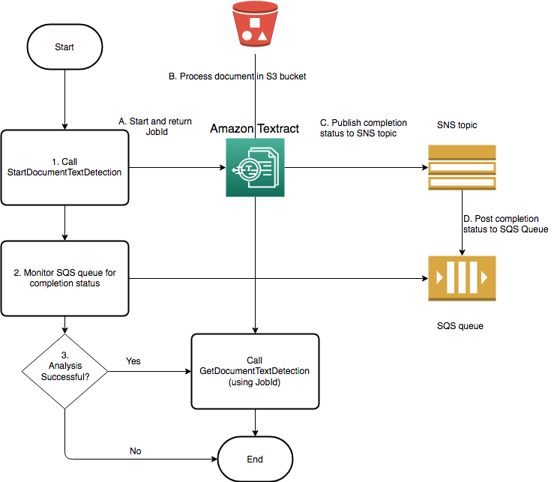

In [13]:
urllib.request.urlretrieve(
  'https://docs.aws.amazon.com/images/textract/latest/dg/images/asynchronous.png', 'textract-asynchronous-process-flow.png')
img = Image.open('textract-asynchronous-process-flow.png')
display(ImageOps.scale(img,0.75))

## 4.0 Expense Document Analysis
<a id=section_4_0></a>

In this section, we will initiate a synchronous expense analysis job, which is designed to detect items in invoices or receipts for data like contact information, items purchased, and vendor names.

### 4.1 Sample document for expense document analysis processing
<a id=section_4_1></a>

Let's have a look at the sample input document we'll use as input for Amazon Textract to perform expense document analysis

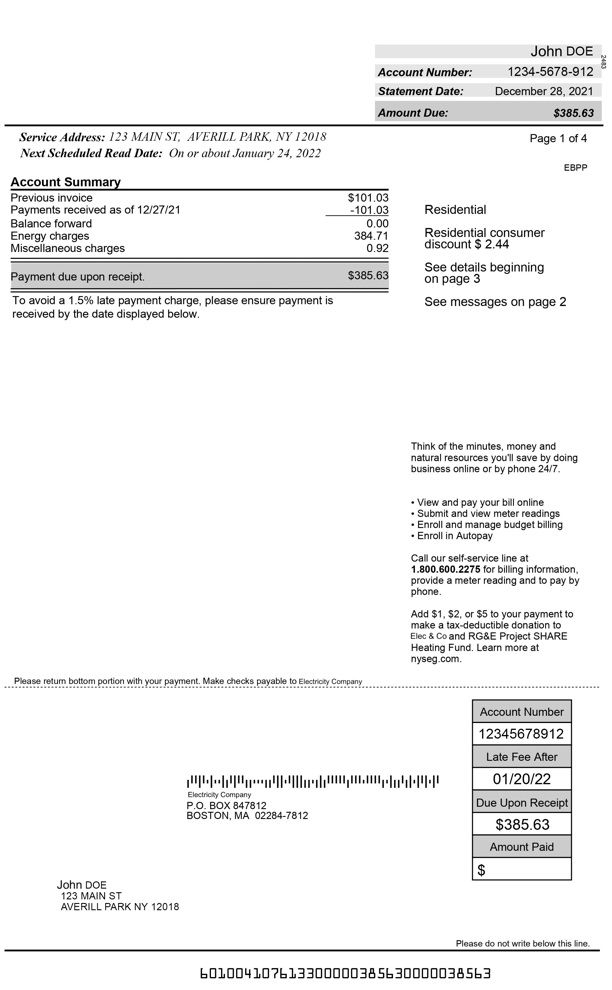

In [14]:
# Sample document
file_name = "Utility_Bill_John_Doe.png"

# The location of the sample PNG image file in your Amazon S3 bucket.
object_key = '{}/{}'.format(s3_bucket_prefix, file_name)

# Display the PNG image 
fs = s3fs.S3FileSystem()
with fs.open('{}/{}'.format(s3_bucket, object_key)) as f:
    display(ImageOps.scale(Image.open(f),0.30))

### 4.2 Execute a synchronous analyze expense job
<a id=section_4_2></a>

Running the cells below will execute the analyze expense job and display detected labels and values for LineItemExpenseFields and SummaryFields

We've created two helper functions to help with parsing and printing:
1. **print_labels_and_values**: displays values if labels are detected and returned
2. **process_expense_analysis**: displays LineItemExpenseFields and SummaryFields, along with their corresponding confidence score. 

Observe that some fields with lower confidence scores may be affected by smaller font size.

In [15]:
def print_labels_and_values(field):
    
    # Only if labels are detected and returned
    if "LabelDetection" in field and "ValueDetection" in field:
        print(
            "Label Detection - Confidence: {}".format(
                str(field.get("LabelDetection")["Confidence"])
            )
            + ", "
            + "Summary Values: {}".format(str(field.get("LabelDetection")["Text"]))
            + "\n"
            + "Value Detection - Confidence: {}".format(
                str(field.get("ValueDetection")["Confidence"])
            )
            + ", "
            + "Summary Values: {}".format(str(field.get("ValueDetection")["Text"]))
            + "\n"
        )

def process_expense_analysis(bucket, document, region):

    # process using S3 object
    response = textract_client.analyze_expense(
        Document={'S3Object': {'Bucket': bucket, 'Name': document}}
    )

    for expense_doc in response["ExpenseDocuments"]:
        for line_item_group in expense_doc["LineItemGroups"]:
            for line_items in line_item_group["LineItems"]:
                for expense_fields in line_items["LineItemExpenseFields"]:
                    print_labels_and_values(expense_fields)

        print("Summary:")
        for summary_field in expense_doc["SummaryFields"]:
            print_labels_and_values(summary_field)

In [16]:
# Execute the job
process_expense_analysis(s3_bucket, object_key, region)

Summary:
Label Detection - Confidence: 99.525634765625, Summary Values: Service Address:
Value Detection - Confidence: 95.42406463623047, Summary Values: 123 MAIN ST, AVERILL PARK, NY 12018

Label Detection - Confidence: 99.7371597290039, Summary Values: Account Number:
Value Detection - Confidence: 99.73905944824219, Summary Values: 1234-5678-912

Label Detection - Confidence: 99.76644897460938, Summary Values: Account Number
Value Detection - Confidence: 99.78838348388672, Summary Values: 12345678912

Label Detection - Confidence: 97.76393127441406, Summary Values: Payments received as of 12/27/21
Value Detection - Confidence: 97.66374206542969, Summary Values: -101.03

Label Detection - Confidence: 71.72782897949219, Summary Values: Amount Paid
Value Detection - Confidence: 71.67349243164062, Summary Values: $

Label Detection - Confidence: 99.81817626953125, Summary Values: Statement Date:
Value Detection - Confidence: 99.46695709228516, Summary Values: December 28, 2021

Label Det

## 5.0 Processing Identity Documents
<a id=section_5_0></a>

In the next two sections, we'll demonstate how to process two common types of identity documents issued by the US Government: a U.S. Driver's License and a U.S. Social Security Card. 
We'll first process a US Driver's license using the Amazon Textract AnalyzeID API. Next, we'll use a feature of the Amazon Textract AnalyzeDocument API called Queries, which allow customers to ask about information within the document using natural language. For example, What is SSN number?

### 5.1 Sample document for identity document analysis processing
<a id=section_5_1></a>

Let's have a look at the sample input document we'll use as input for Amazon Textract to perform identity document analysis

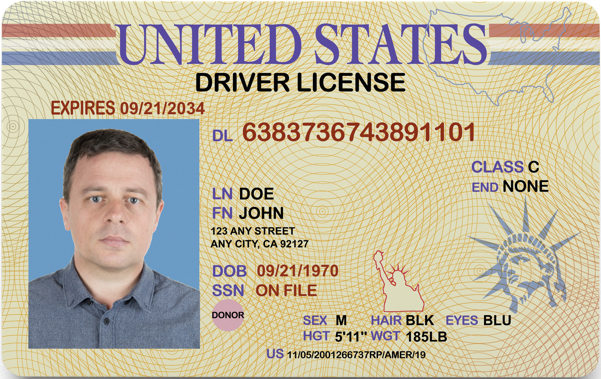

In [17]:
# Sample document
file_name = "drivers-license.png"

# The location of the sample PNG image file in your Amazon S3 bucket.
object_key = '{}/{}'.format(s3_bucket_prefix, file_name)

# Display the PNG image 
fs = s3fs.S3FileSystem()
with fs.open('{}/{}'.format(s3_bucket, object_key)) as f:
    display(ImageOps.scale(Image.open(f),0.30))

### 5.2 Execute a synchronous analyze identity process
<a id=section_5_2></a>

In this code cell, we also use [Amazon Textract Caller tools](https://pypi.org/project/amazon-textract-caller/), which provide a collection of ready to use functions and sample implementations to speed up the evaluation and development for any project using Amazon Textract.

The AnalyzeID API returns information in a structure called IdentityDocumentFields, which contains the normalized keys and their corresponding value. 
For example, the FIRST_NAME key corresponds to the value of John

In [18]:
# Using Amazon Textract Caller tools to call Textract AnalyzeId 
response_drivers_license = call_textract_analyzeid(document_pages=[f's3://{s3_bucket}/{object_key}'])

# Here we iterate of the collection IdentityDocuments and IdentityDocumentFields
for id_docs in response_drivers_license['IdentityDocuments']:
    id_doc_kvs={}
    for field in id_docs['IdentityDocumentFields']:
        if field['ValueDetection']['Text']:
            id_doc_kvs[field['Type']['Text']] = field['ValueDetection']['Text']

# Display the key/value pairs detected by Textract
print(json.dumps(id_doc_kvs, indent=4))

{
    "FIRST_NAME": "JOHN",
    "LAST_NAME": "DOE",
    "CITY_IN_ADDRESS": "ANY CITY",
    "ZIP_CODE_IN_ADDRESS": "92127",
    "STATE_IN_ADDRESS": "CA",
    "STATE_NAME": "UNITED STATES OF STATE",
    "DOCUMENT_NUMBER": "6383736743891101",
    "EXPIRATION_DATE": "09/21/2034",
    "DATE_OF_BIRTH": "09/21/1970",
    "ID_TYPE": "DRIVER LICENSE FRONT",
    "ENDORSEMENTS": "NONE",
    "CLASS": "C",
    "ADDRESS": "123 ANY STREET"
}


### 5.3 Sample identity document for document analysis queries
<a id=section_5_3></a>

Let's have a look at the sample input document we'll use as input for Amazon Textract to perform a document analysis using queries.

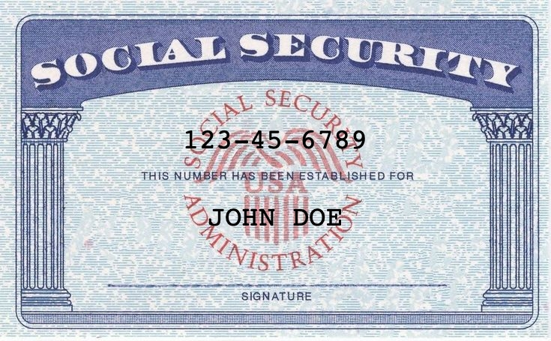

In [19]:
# Sample document
file_name = "SSN_John_Doe.jpg"

# The location of the sample PNG image file in your Amazon S3 bucket.
object_key = '{}/{}'.format(s3_bucket_prefix, file_name)

# Display the PNG image 
fs = s3fs.S3FileSystem()
with fs.open('{}/{}'.format(s3_bucket, object_key)) as f:
    display(ImageOps.scale(Image.open(f),0.75))

### 5.4 Processing a U.S. Social Security Card with Queries
<a id=section_5_4></a>

In the following cell observe that, in the asynchronous start_analyze_job() function, there are two queries in the JSON request: **"What is SSN number?"** and **"What is the name on SSN?"**. Each query contains the question you want to ask in the **Text** attribute and the **Alias** attribute you want to associate with the question, returned in the JSON response. The aliases to the aforementioned questions are **"SSN_NUMBER"** and **"SSN_OWNER_NAME"**, respectively. Additionally, there are two helper functions to help with monitoring the analyze document job status and displaying the query results.

In [20]:
def start_analyze_job(s3_bucket, key_name):
    response = None
    response = textract_client.start_document_analysis(
        DocumentLocation={
            'S3Object': {
                'Bucket': s3_bucket,
                'Name': key_name
            }
        },
        FeatureTypes=['QUERIES'],
        QueriesConfig={
            "Queries": [
            {
                "Text": "What is SSN number?",
                "Alias": "SSN_NUMBER"
            },
            {
                "Text": "What is the name on SSN?",
                "Alias": "SSN_OWNER_NAME"
            }
          ]},
        OutputConfig={
            'S3Bucket': s3_bucket,
            'S3Prefix': 'textract-output/ssn'
        }
    )

    return response["JobId"]

def is_job_complete(jobId):
    response = textract_client.get_document_analysis(JobId=jobId)
    status = response["JobStatus"]
    print("Job status: {}".format(status))

    while(status == "IN_PROGRESS"):
        time.sleep(5)
        response = textract_client.get_document_analysis(JobId=jobId)
        status = response["JobStatus"]
        print("Job status: {}".format(status))

    return status

def print_result_in_document(response):
    doc = t2.TDocumentSchema().load(response[0])
    page = doc.pages[0]
    doc_query_answers = doc.get_query_answers(page=page)
    print(tabulate(doc_query_answers, tablefmt="github"))

In [21]:
# Main code for execution
# -----
job_id = start_analyze_job(s3_bucket, object_key)

# Monitor the job status
print("Started analyze job with id: {}, document is: {}".format(job_id, object_key))
if(is_job_complete(job_id)):
    ssn_response = get_job_results(job_id)

# Print the result
print_result_in_document(ssn_response)

Started analyze job with id: 1c9e1057e0ab8036d4d622c87513bf90ad9de511a3d8be0d569f94936401c5ae, document is: aim204/sample-files/SSN_John_Doe.jpg
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: SUCCEEDED
Result page recieved: 1
|--------------------------|----------------|-------------|
| What is the name on SSN? | SSN_OWNER_NAME | JOHN DOE    |
| What is SSN number?      | SSN_NUMBER     | 123-45-6789 |


## 6. Document Enrichment using Redaction (Optional)
<a id=section_6_0></a>

Redacting personally identifiable information within documents is important to avoid identity theft. Redaction is a form of document enrichment used to conceal or remove confidential information.
In this code cell, we demonstrate how to use the Geometry data type within the JSON response object to draw a solid black rectangle over the social security number on the SSN card. 

We'll resuse the job results from the previous section since we just need to parse the JSON response and check if any of the query results (i.e. the answers to our questions) contain a digit -- if so, then we get the geometric coordinates of the query result and draw a solid black rectangle. 

In [22]:
def ssn_redaction(response, s3_bucket, object_key):

    fs = s3fs.S3FileSystem()
    with fs.open('{}/{}'.format(s3_bucket, object_key)) as f:
        img = Image.open(f)
        width, height = img.size

        # Add redaction to SSN
        for item in response[0]["Blocks"]:
            if item["BlockType"] == "QUERY_RESULT":
                result = any([char.isdigit() for char in item["Text"]])
                if(result):
                    x1 = item["Geometry"]["BoundingBox"]["Left"]*width
                    y1 = item["Geometry"]["BoundingBox"]["Top"]*height-2
                    x2 = x1 + (item["Geometry"]["BoundingBox"]["Width"]*width)+5
                    y2 = y1 + (item["Geometry"]["BoundingBox"]["Height"]*height)+2

                    draw = ImageDraw.Draw(img)
                    draw.rectangle([x1, y1, x2, y2], fill="Black")
                    display(img)

Result page recieved: 1


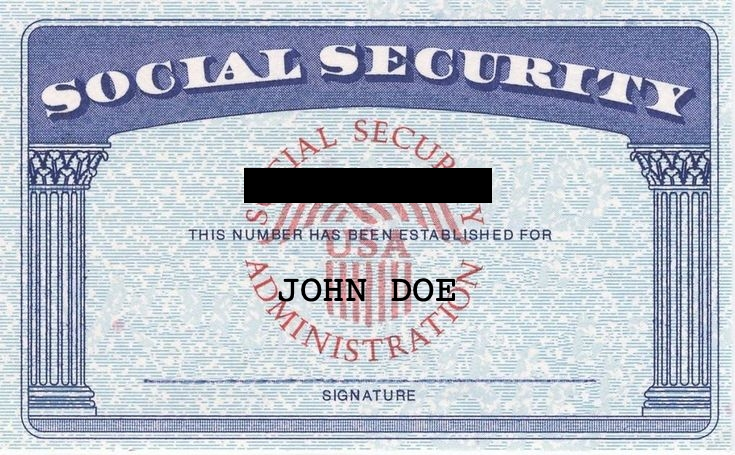

In [23]:
# Main code for execution
# -----

# Let's reuse the job_id from the previous section
response = get_job_results(job_id)

# Redact the SSN
ssn_redaction(response, s3_bucket, object_key)

## 7. Conclusion
<a id=section_7_0></a>

In this lab we demonsrated how to use Amazon Textract to programatically perform common document processing tasks such as detecting text within a document, analyzing a document for relationships between detected items, using asynchronous operations, analyzing a document for financially-related relationships between text, and performing document redaction.

For customers looking for a GUI interface, Amazon Textract also offers many of the same capabilities via the AWS Management console. 

For customers looking for an Amazon Textract Partner from the AWS Partner Network, [click here](https://aws.amazon.com/textract/partners/).



## 8. Additional Resources
<a id=section_8_0></a>

- https://docs.aws.amazon.com/textract/latest/dg/API_BoundingBox.html
- https://docs.aws.amazon.com/textract/latest/dg/text-location.html
- https://docs.aws.amazon.com/textract/latest/dg/how-it-works-lines-words.html